In [ ]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import seaborn as sns
#from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from glob import glob
from collections import defaultdict
import scipy


In [ ]:
sns.set_theme()
#sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})

In [282]:
#data_dir = '/s/project/mll/sergey/effect_prediction/MLM/motif_predictions/split_75_25/'
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/motif_predictions/split_75_25/'

In [283]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

In [284]:
motif_len = 5 #5 or 6

In [285]:
table_motifs = pd.read_csv(data_dir + f'../motifs_k{motif_len}.csv')
table_motifs.loc[table_motifs.protein.isna(), 'protein'] = 'Random' 

In [ ]:
eclip_pos_intervals = pd.read_pickle(data_dir + '../../eCLIP/eCLIP_intervals_3UTR.df')

In [286]:
models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-agnostic':'../species_agnostic/probas',
          'Species-aware':'../species_aware/probas', 'DNABERT': 'dnabert/default/'}

models = {'11-mer':'11_mer','Species-agnostic':'../species_agnostic/probas',
          'Species-aware':'../species_aware/probas', 'DNABERT': 'dnabert/default/'}


#models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-agnostic':'../species_agnostic_tempscale/probas',
#          'Species-aware':'../species_aware_tempscale/probas', 'DNABERT': 'dnabert/default/'}

In [287]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [288]:
def get_dnabert(res_path):
    res = {}
    for probas_file in glob(res_path + 'preds*.npy'):
        seq_matching = pd.read_csv(probas_file.replace('/preds','/seq').replace('.npy','.csv')).set_index('seq_name').squeeze()
        probas = np.load(probas_file)
        s = 0
        for seq_name, seq in seq_matching.items():
            res[seq_name] = [x[mapping[seq[seq_idx]]] for seq_idx,x in enumerate(probas[s:s+len(seq),:])]
            s += len(seq)
        assert s==len(probas)
    return res

In [289]:
def get_dnabert_tscale(res_path, temperature = 9486):
    #use temp_scale_dnabert for calibration
    res_t_scale = {} #calibrated probas
    res = {} #uncalibrated softmax probas
    for probas_file in glob(res_path + 'logits*.npy'):
        seq_matching = pd.read_csv(probas_file.replace('/logits_','/seq_').replace('.npy','.csv')).set_index('seq_name').squeeze()
        logits = np.load(probas_file)
        probas_t_scale = scipy.special.softmax(logits / temperature,axis=1) 
        probas = scipy.special.softmax(logits,axis=1) 
        s = 0
        for seq_name, seq in seq_matching.items():
            #res[seq_name] = [x[mapping[seq[seq_idx]]] for seq_idx,x in enumerate(probas[s:s+len(seq),:])]
            res[seq_name] = probas[s:s+len(seq),:]
            res_t_scale[seq_name] = probas_t_scale[s:s+len(seq),:]
            s += len(seq)
        assert s==len(probas)
    return res, res_t_scale

In [290]:
res = {}

for model, model_path in models.items():
    if model!='DNABERT':
        with open(data_dir + model_path + '.pickle','rb') as f:
            res[model] = dict(pickle.load(f))
    else:
        res[model] = get_dnabert(data_dir + model_path)
        #_,res[model] = get_dnabert_tscale(data_dir + model_path)

In [292]:
def is_interval_in_seq(find_me, interval_seq):
    '''
    checks if a given interval is in a sequence of intervals
    the sequence should be sorted by the 0th coordinate
    '''
    for interval in interval_seq:
        if find_me[-1]<interval[0]:
            # since interval_seq is sorted by the 0th coordinate, there is no more chance to encounter a region containing find_me
            return False
        # sought interval is included in the current interval
        if find_me[0]>=interval[0] and find_me[1]<=interval[1]:
            return True
    
    return False

In [293]:
motifs_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    #if not seq_name in res['DNABERT']:
    #    continue
    if seq_name in eclip_pos_intervals.index:
        eCLIP_valid_intervals = eclip_pos_intervals.loc[seq_name]
    else:
        eCLIP_valid_intervals = []
    for protein, motif in table_motifs.set_index('protein').squeeze().items():
        label = f'{protein}\n{motif}' if protein!='Random' else 'Random'
        motif_mapping = [list(range(len(motif))),list(map(lambda x:mapping[x],motif))]
        for match in re.finditer(motif,seq):
            is_eCLIP = is_interval_in_seq((match.start(),match.end()),eCLIP_valid_intervals)
            for model in models:
                if 'Species' in model:
                    avg_target_prob = np.mean(res[model][seq_name][match.start():match.end()][motif_mapping[0], motif_mapping[1]])
                else:
                    avg_target_prob = np.mean(res[model][seq_name][match.start():match.end()])
                motifs_df.append((model,seq_name,match.start(),label,motif,avg_target_prob,is_eCLIP))

100%|██████████| 4534/4534 [04:42<00:00, 16.03it/s]


In [294]:
motifs_df = pd.DataFrame(motifs_df,columns = ['model','seq_name','motif_start','label','motif','avg_target_prob','is_eCLIP'])

In [295]:
selected_proteins = ['EWSR1', 'HNRNPL', 'PABPN1L', 'KHSRP', 'RBFOX2', 'HNRNPC', 'PUM1', 'FUS', 'TAF15',
                     'TRA2A', 'PCBP2', 'TARDBP', 'TIA1', 'PTBP3', 'CELF1', 'FUBP3', 'KHDRBS2'] #top motifs overlap for RBNS and eCLIP

In [296]:
selected_motifs = table_motifs[table_motifs.protein.isin(selected_proteins)].drop_duplicates(subset='protein',keep='first').drop_duplicates(subset='motif')
#selected_motifs = pd.concat([table_motifs[table_motifs.protein=='Random'],selected_motifs]) #add random motifs
selected_motifs = selected_motifs.set_index('protein').squeeze() #convert to series

In [297]:
#selected_labels = ['Random'] + (selected_motifs.index + '\n' + selected_motifs).tolist()

/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will 

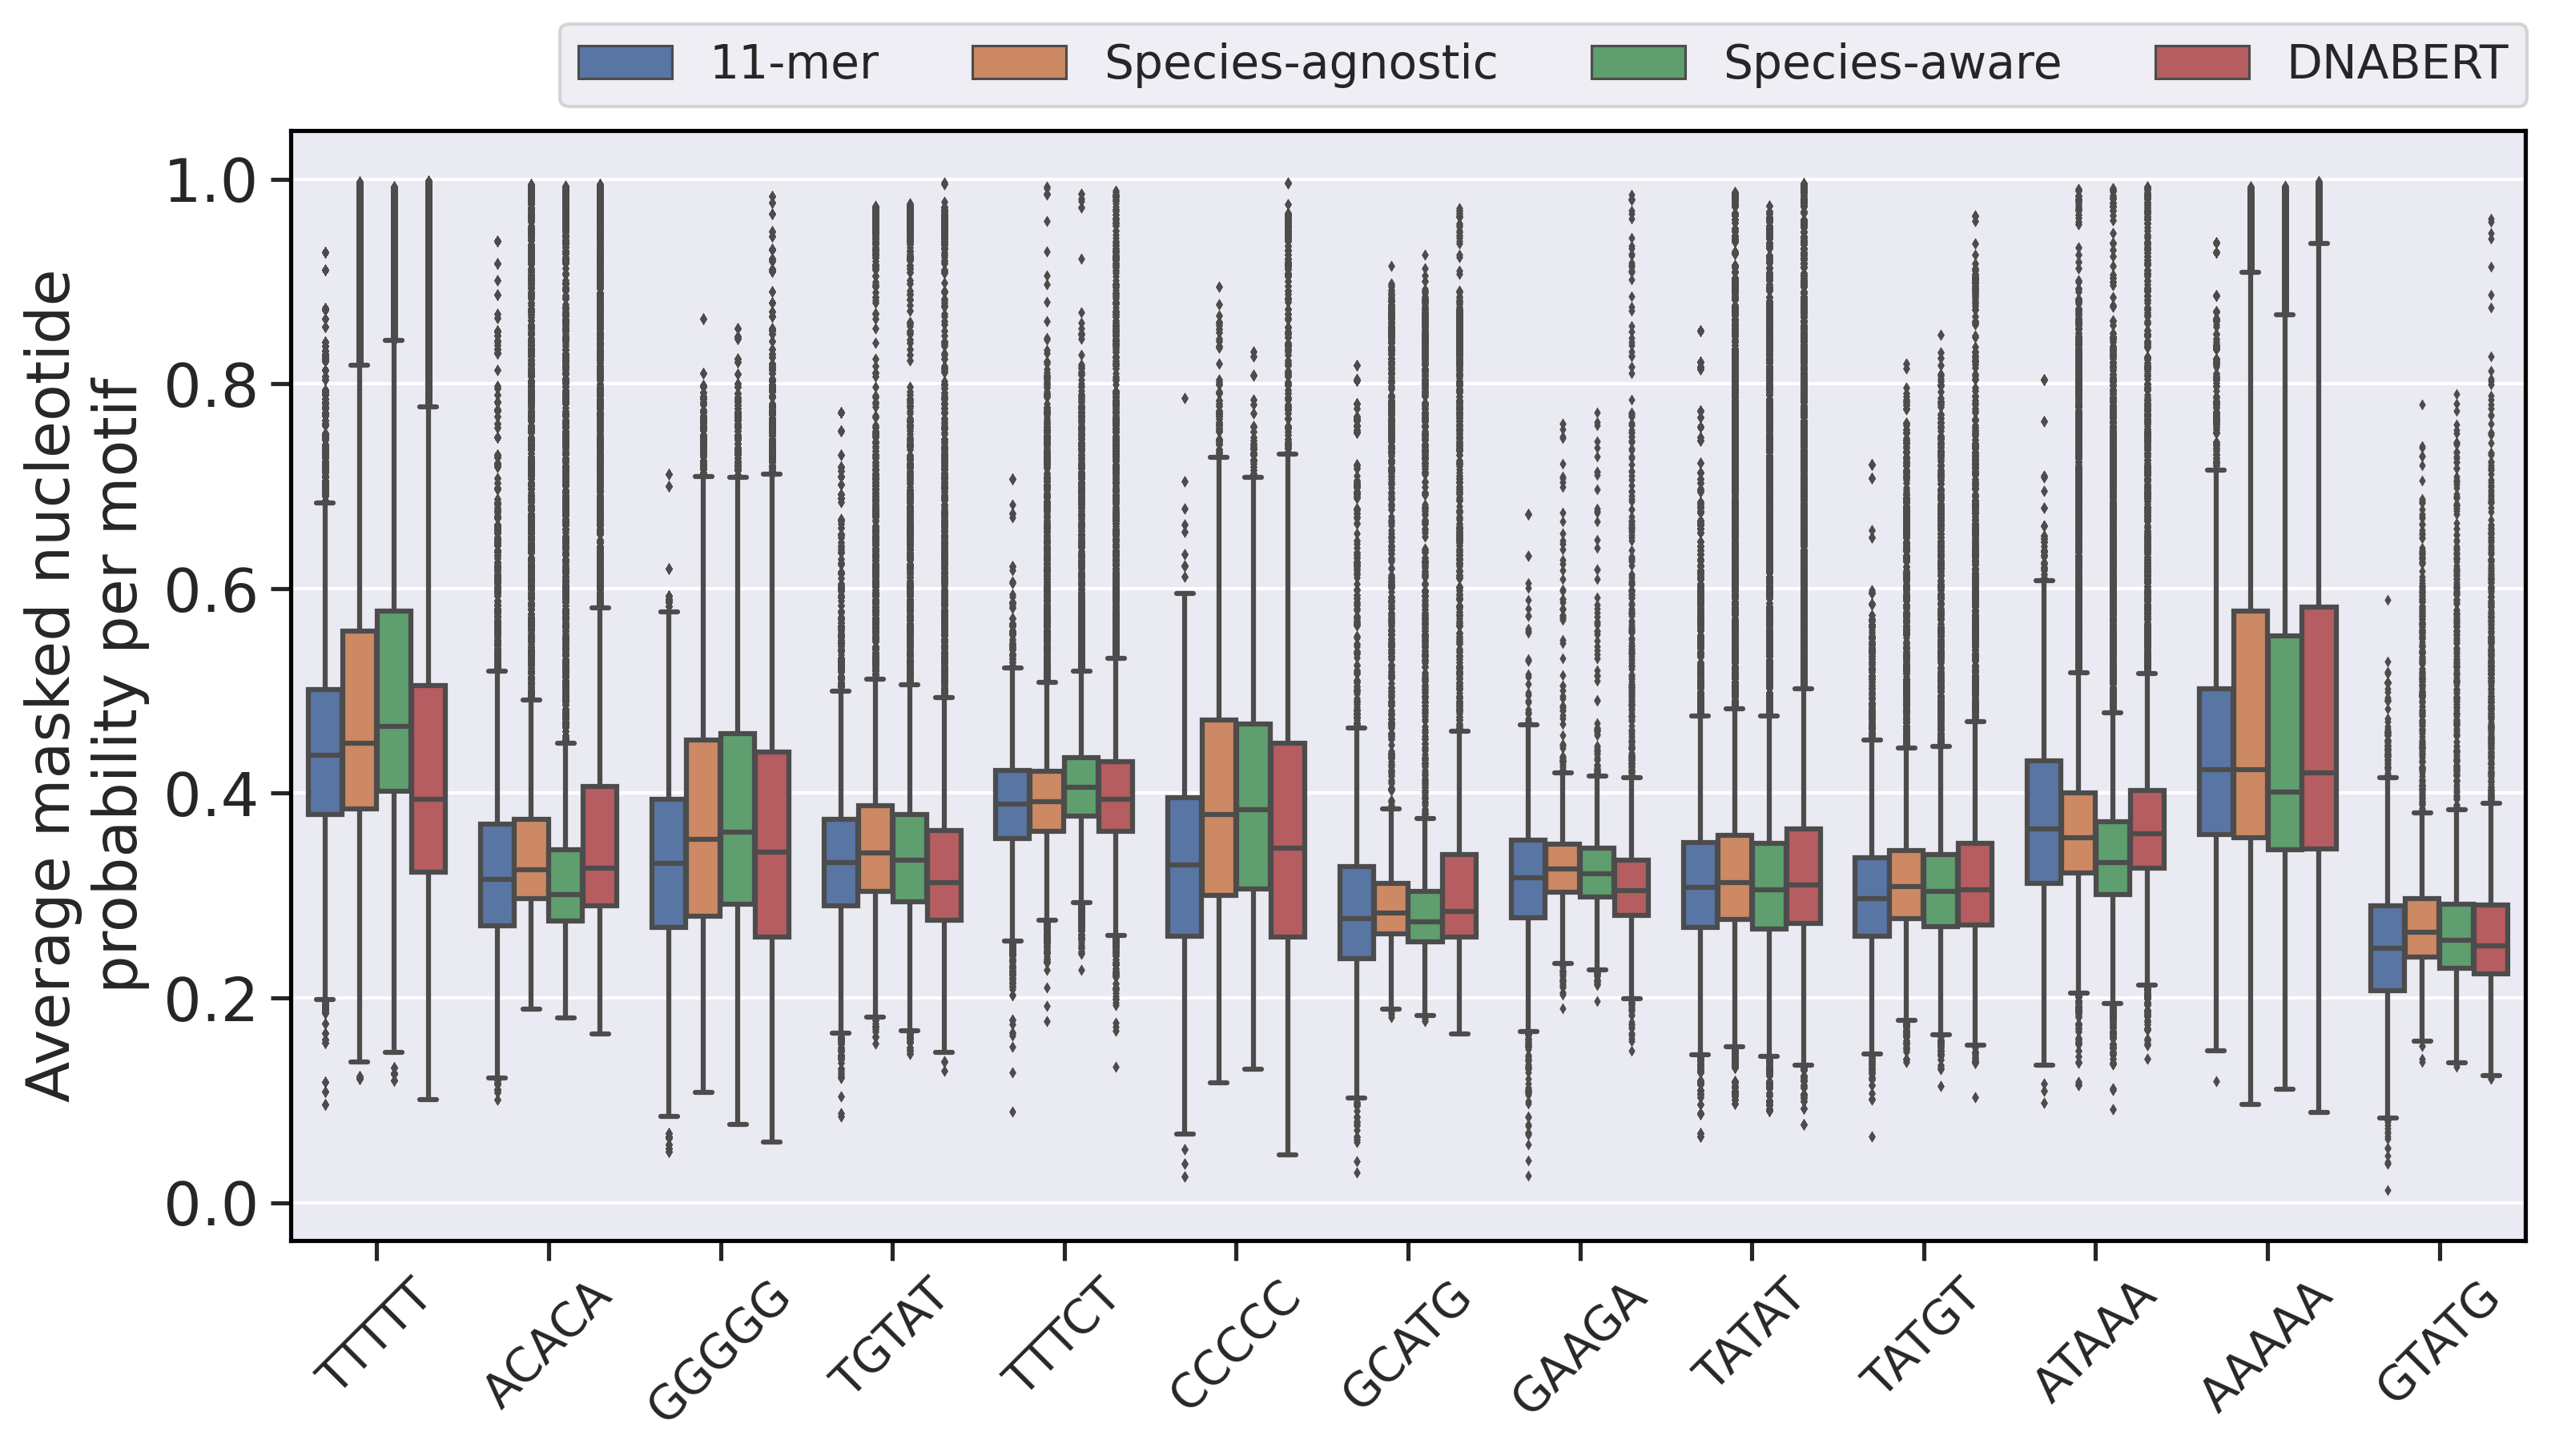

In [298]:
fig, ax = plt.subplots(figsize=(12,6),dpi=300)

plot_data = motifs_df[(motifs_df.motif.isin(selected_motifs))&(motifs_df.is_eCLIP)]

#ax = sns.catplot(data=plot_data, x="motif", y="avg_target_prob", hue="model",
#                kind="box", height=10, aspect=2.0, estimator=np.mean,zorder=3, legend=False)#, palette=custom_colors)

sns.boxplot(data=plot_data, x="motif", y="avg_target_prob", hue="model", fliersize=1, ax=ax)#, palette=custom_colors)


p1 = [((motif,'Species-aware'),(motif,'Species-agnostic')) for motif in selected_motifs]
p2 = [((motif,'DNABERT'),(motif,'Species-agnostic')) for motif in selected_motifs]
p3 = [((motif,'Species-aware'),(motif,'DNABERT')) for motif in selected_motifs]
box_pairs = p1+p2+p3

annotator = Annotator(ax, box_pairs, data=plot_data, x="motif", y="avg_target_prob",hue="model",plot='boxplot',)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

#annotator.apply_and_annotate()

ax.tick_params(labelsize=18)  

plt.xticks(rotation = 45, fontsize=14)

#plt.axhline(0.25,color="r", zorder=-1, linestyle='--');

plt.legend(loc='lower left', ncols=5, bbox_to_anchor=(0.11, 1), fontsize=14)
plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif", fontsize=18)
plt.show()

In [299]:
from scipy import stats
import statsmodels.stats.multicomp as mc

In [300]:
def get_best_models(df, alpha=0.05):
    
    comp1 = mc.MultiComparison(df['avg_target_prob'], df['model'])
    tbl, a1, a2 = comp1.allpairtest(stats.wilcoxon, method= "bonf") #Wilcoxon test with Bonferroni correction

    models_stats = pd.DataFrame(a2).set_index(['group1','group2']) #see if the difference between pairs of models is significant
    
    #we ignore default Bonferroni correction as it is for wrong number of pairs in the study
    models_stats.reject = models_stats.pval<alpha

    per_model_scores = df.groupby('model').apply(lambda x: x.avg_target_prob.mean()).sort_values(ascending=False) #compute score based on all predictions for a given model

    sorted_models = per_model_scores.keys() #get models ranking list, scoring in descending order

    best_models = [sorted_models[0]] #always include best model

    #loop over the list and add models until the difference between current and subsequent models is significant
    for model_idx in range(len(sorted_models)-1):

        #two keys are possible for a given pair of models
        idx_2models = (sorted_models[model_idx], sorted_models[model_idx+1]) 
        idx_2models_swap = (sorted_models[model_idx+1], sorted_models[model_idx])

        if ((idx_2models in models_stats.index and models_stats.loc[idx_2models].reject==False) 
                or (idx_2models_swap in models_stats.index and models_stats.loc[idx_2models_swap].reject==False)):
                    best_models.append(sorted_models[model_idx+1])
        else:
            #as soon as significant difference is detected, dont add models to the best models list
            break
            
    return best_models

In [301]:
def highlight_ns(x, best_models):
    #make the best model and models with insignificant difference with the best model bold
    motif = x.name
    return ['font-weight: bold' if model in best_models[motif] else ''
                for model in x.index]

In [302]:
n_pairs = (len(models)-1)*len(selected_motifs) # number of pairs for comparison: 4 models + 13 motifs
alpha = 0.05/n_pairs

best_models = {}

for motif in selected_motifs:
    df = motifs_df[(motifs_df.motif==motif)&(motifs_df.is_eCLIP)]
    best_models[motif] = get_best_models(df, alpha)

In [303]:
avg_probas_df = motifs_df.groupby(['motif','model']).avg_target_prob.mean().reset_index()

In [304]:
avg_probas_df = pd.pivot_table(avg_probas_df, index='motif', columns=['model'], values='avg_target_prob')

In [305]:
avg_probas_df = avg_probas_df.loc[selected_motifs].applymap(lambda x:f'{x:.2f}')

/tmp/ipykernel_1533711/2300146569.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  avg_probas_df = avg_probas_df.loc[selected_motifs].applymap(lambda x:f'{x:.2f}')


In [306]:
avg_probas_df.style.apply(lambda x: highlight_ns(x, best_models),axis=1)

model,11-mer,DNABERT,Species-agnostic,Species-aware
motif,,,,
TATGT,0.30,0.35,0.33,0.32
GGGGG,0.33,0.37,0.36,0.37
TATAT,0.33,0.38,0.36,0.35
TTTTT,0.46,0.46,0.51,0.52
ACACA,0.35,0.42,0.40,0.37
ATAAA,0.38,0.40,0.42,0.39
TGTAT,0.35,0.37,0.37,0.36
AAAAA,0.46,0.51,0.51,0.50
CCCCC,0.33,0.37,0.39,0.39
